In [1]:
import pandas as pd
import numpy as np
from keras.layers import Dense, Activation, Input, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.model_selection import KFold

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Variables

In [4]:
file_name = 'data/merchants_data.csv'

### Load and prepare data

In [5]:
data = pd.read_csv(file_name, sep="?") # Data previously separated with ?

In [6]:
data.shape

(65983, 3)

In [7]:
data.columns

Index(['merchant_string', 'raw_trans_string', 'clean_trans_string'], dtype='object')

Filter rows to keep the ones only containing the merchant string (substring) in the raw_trans_string

In [8]:
data = data[data.apply( lambda x: x[0].lower() in x[1].lower(), axis=1)]

In [9]:
data = data.drop_duplicates("raw_trans_string")

In [10]:
data = data.reset_index(drop=True)

In [11]:
data = data.sample(data.shape[0]) # Randomize data

In [12]:
data['raw_trans_string'] = data['raw_trans_string'].str.replace(r'\s+', ' ')

In [13]:
data.shape

(13331, 3)

In [14]:
# Add begin marker cell to the dataframe

In [15]:
data["begin_marker"] = data[['merchant_string','raw_trans_string']].apply(lambda x: x[1].lower().find(x[0].lower()), axis=1)

In [16]:
# Add end marker cell to the dataframe

In [17]:
data['end_marker'] = data[['merchant_string', 'begin_marker']].apply(lambda x: x[1] + len(x[0]), axis=1)

In [18]:
data.head()

merchant_string                      raw_trans_string  \
144           Chevron                      CHEVRON 00042085   
5545      Chick-Fil-A        CHICK-FIL-A #00945 COLUMBIA SC   
7860          Verizon  VERIZON*RECURRING PAY 800-VERIZON FL   
12922       Applebees  APPLEBEES 866263686620 BROOKFIELD WI   
9410           Sheetz         SHEETZ 00002253 BREEZEWOOD PA   

          clean_trans_string  begin_marker  end_marker  
144                  CHEVRON             0           7  
5545             CHICK-FIL-A             0          11  
7860   VERIZON RECURRING PAY             0           7  
12922              APPLEBEES             0           9  
9410                  SHEETZ             0           6

In [19]:
for _ in range(100):
    i = np.random.randint(data.shape[0])
    extracted_merchant_name = data["raw_trans_string"].loc[i][data["begin_marker"][i]:data["end_marker"][i]]
    orig_merchant_name = data['merchant_string'].loc[i]
    assert(extracted_merchant_name.lower() == orig_merchant_name.lower())

In [20]:
# Create vocabulary with UNKNOWNS AND PAD Symbols

In [21]:
UNKNOWN = 'UNKNOWN'
PAD = 'PAD'
vocab = [UNKNOWN, PAD]

In [22]:
chars = set([ c for text in data['raw_trans_string'].values for c in text ])

In [23]:
for c in chars:
    vocab.append(c)

In [24]:
char2index = dict((c, i) for i, c in enumerate(vocab)) # Unnecessary variables but easier
index2char = dict((i, c) for i, c in enumerate(vocab))

#### Create training/testing

In [25]:
pad_size = 200 # Padding up to 200 PAD Symbols to the text

In [26]:
data['encoded_text'] = [ [char2index[char] for char in text] for text in data['raw_trans_string'].values ]

In [27]:
def pad_vector(vector, pad_size, padding):
    vector[len(vector):pad_size] = np.repeat(padding, pad_size - len(vector))
    return vector

In [28]:
data['encoded_text_padded'] = data[['encoded_text']].apply( lambda x: pad_vector(x[0], pad_size, char2index[PAD] ), axis=1)

In [29]:
assert(len(data['encoded_text_padded'].loc[0]) == pad_size) # Encoded text has same number of characters as original string plus the marquers

In [30]:
#### One hot encoding text

In [31]:
X = np.zeros((data['encoded_text_padded'].shape[0], pad_size, len(vocab)))

In [32]:
for i, vector in enumerate(data['encoded_text_padded'].values):
    for j, char in enumerate(vector):
        X[i, j, char] = 1

In [33]:
### Create Targets

In [34]:
Y_begin = to_categorical(data['begin_marker'].values, int(pad_size / 2))
Y_end = to_categorical(data['end_marker'].values, int(pad_size / 2))

In [35]:
### Build NN

In [36]:
BATCH = 32
EPOCHS = 4

In [41]:
def build_model(input_shape):
    model = Sequential()
    model.add(Dense(input_shape[0], input_shape=input_shape, activation="relu"))
    model.add(Flatten())
    model.add(Dense(int(input_shape[0] / 2)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
    return model

In [42]:
def build_dyn_model(input_shape, layers):
    model = Sequential()
    for i,layer in enumerate(layers):
        if i == 0:
            model.Add(Dense(layer.hidden_nb, input_shape=input_shape, activation=layer.activation))
        else:
            model.add(Flatten())
            mode.Add(Dense(layer.hidden, activation=layer.activation))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
    return model

In [43]:
### Train and test simple

In [44]:
model = build_model((pad_size, len(vocab)))

In [45]:
#Y = np.array([hot_encode_index_pos(index, pad_size) for index in data[['begin_marker']].values ])

In [46]:
model_output = model.fit(X, Y_begin, batch_size=BATCH, epochs=EPOCHS)

Epoch 1/4
13331/13331 [==============================] - 12s 897us/step - loss: 0.3708 - acc: 0.9350
Epoch 2/4
13331/13331 [==============================] - 5s 379us/step - loss: 0.1867 - acc: 0.9569
Epoch 3/4
13331/13331 [==============================] - 5s 380us/step - loss: 0.1269 - acc: 0.9668
Epoch 4/4
13331/13331 [==============================] - 5s 380us/step - loss: 0.0950 - acc: 0.9723


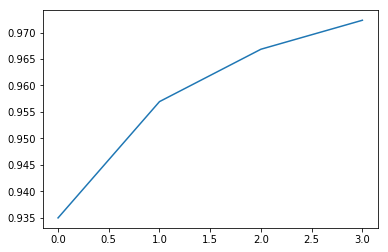

In [47]:
pyplot.plot(model_output.history['acc'])

In [48]:
pyplot.show()

In [49]:
#### Cross validation for begin marker

In [50]:
kfold = KFold(n_splits=5)

In [51]:
def accuracy_model(y_true, y_predicted):
    nb_predicted = sum([ y_true[i, np.argmax(y_predicted[i])] for i in range(len(y_predicted)) ])
    return nb_predicted / len(y_predicted)

In [52]:
for train, test in kfold.split(X):
    model = build_model((pad_size, len(vocab)))
    model.fit(X[train], Y_begin[train], BATCH, EPOCHS)
    print("Model accuracy %f" % accuracy_model(Y_begin[test], model.predict(X[test])))

Epoch 1/4
10664/10664 [==============================] - 4s 406us/step - loss: 0.3860 - acc: 0.9330
Epoch 2/4
10664/10664 [==============================] - 4s 402us/step - loss: 0.1824 - acc: 0.9578
Epoch 3/4
10664/10664 [==============================] - 4s 387us/step - loss: 0.1106 - acc: 0.9682
Epoch 4/4
10664/10664 [==============================] - 4s 406us/step - loss: 0.0713 - acc: 0.9776
Model accuracy 0.938883
Epoch 1/4
10665/10665 [==============================] - 4s 406us/step - loss: 0.3882 - acc: 0.9319
Epoch 2/4
10665/10665 [==============================] - 4s 390us/step - loss: 0.1769 - acc: 0.9576
Epoch 3/4
10665/10665 [==============================] - 4s 390us/step - loss: 0.1130 - acc: 0.9693
Epoch 4/4
10665/10665 [==============================] - 4s 401us/step - loss: 0.0774 - acc: 0.9771
Model accuracy 0.954239
Epoch 1/4
10665/10665 [==============================] - 4s 418us/step - loss: 0.4018 - acc: 0.9300
Epoch 2/4
10665/10665 [=============================

In [49]:
### Cross validation for end marker

In [50]:
for train, test in kfold.split(X):
    model = build_model((pad_size, len(vocab)))
    model.fit(X[train], Y_end[train], BATCH, EPOCHS)
    print("Model accuracy %f" % accuracy_model(Y_end[test], model.predict(X[test])))

Epoch 1/4
10664/10664 [==============================] - 10s 955us/step - loss: 0.9162 - acc: 0.7800
Epoch 2/4
10664/10664 [==============================] - 11s 1ms/step - loss: 0.2337 - acc: 0.9375
Epoch 3/4
10664/10664 [==============================] - 11s 1ms/step - loss: 0.1192 - acc: 0.9683
Epoch 4/4
10664/10664 [==============================] - 12s 1ms/step - loss: 0.0687 - acc: 0.9822
Model accuracy 0.928384
Epoch 1/4
10665/10665 [==============================] - 11s 988us/step - loss: 0.9321 - acc: 0.7718
Epoch 2/4
10665/10665 [==============================] - 11s 1ms/step - loss: 0.2327 - acc: 0.9356
Epoch 3/4
10665/10665 [==============================] - 11s 1ms/step - loss: 0.1242 - acc: 0.9663
Epoch 4/4
10665/10665 [==============================] - 14s 1ms/step - loss: 0.0687 - acc: 0.9832
Model accuracy 0.926482
Epoch 1/4
10665/10665 [==============================] - 12s 1ms/step - loss: 0.9148 - acc: 0.7751: 0s - loss: 0.9164 - acc: 0.774
Epoch 2/4
10665/10665 [==

In [195]:
a = model.predict(X[test[0]:test[0]+1])

In [200]:
np.argmax(a[0])

6